In [92]:
# Read Data
import numpy as np
import pandas as pd

In [93]:
%run ../src/campus_src.py

In [94]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [95]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
#n_steps = 8  # 例如，使用t以及前面5步作為特徵
#論文設定成3
n_steps = 3
X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[222.326142 220.546435 205.955438 ...  73.581269 156.333926 222.44631 ]
(4316, 3, 35)
(4316,)


## Split

In [96]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.15)

## Attack

In [97]:
def attack_all_add_pct(X, step_idx=7, feat_idx=1, pct=0.05):
    """
    对 X 中所有样本，在指定的 step_idx 和 feat_idx 位置，
    将原值增加 pct * 原值（即乘以 1+pct）。

    参数：
        X (np.ndarray): 待“攻击”的三维数组，shape=(n_samples, n_steps, n_features)
        step_idx (int): 时间步的索引，比如第8步就传 7
        feat_idx (int): 特征的索引，比如第2个特征就传 1
        pct (float): 增加比例，默认 0.05（5%）

    返回：
        np.ndarray: 攻击后的数组副本
    """
    X_attacked = X.copy()
    X_attacked[:, step_idx, feat_idx] *= (1 + pct)
    return X_attacked

#X_test_attacked = attack_all_add_pct(X_test, step_idx=7, feat_idx=1, pct=0.2)
#X_test_attacked = attack_all_add_pct(X_test_attacked, step_idx=7, feat_idx=2, pct=0.2)

#X_test = X_test_attacked.copy()

## Scaler

In [98]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [99]:
"""
for i in range(len(X_train)): #每個X_train
  # 应用噪声
  X_train[i] = add_noise(X_train[i], noise_level=0.05)
"""

'\nfor i in range(len(X_train)): #每個X_train\n  # 应用噪声\n  X_train[i] = add_noise(X_train[i], noise_level=0.05)\n'

In [100]:
import tcn
from tensorflow.keras.models import load_model

# load capacity model
model = load_model("../models/tf/capacity.keras", compile=False)


In [101]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [ ]:
# 訓練 traffic forecasting model
traffic_model = build_model_TCN(n_steps, X_train.shape[2])
history = traffic_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

# 注入
epsilon = 0.2
X_test_adv = None
# 时间维度上，论文中的 FGSM 只针对 当前时刻 𝑡 的快照进行扰动，不会“连带”把 𝑡 − 1 , 𝑡 − 2 , … t−1,t−2,… 一并改动；
X_test_adv = fgsm_inject_one_pos(traffic_model, X_test, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=1)
X_test_adv = fgsm_inject_one_pos(traffic_model, X_test_adv, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=2)
##??? 這邊要改吧 為什麼做兩次
preds_clean = traffic_model.predict(X_test)
preds_adv   = traffic_model.predict(X_test_adv)    # 一定要传 X_test_adv
print("max abs diff:", np.max(np.abs(preds_adv - preds_clean)))

/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_1 (TCN)                     │ (None, 64)             │        97,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 106.1647 - val_loss: 37.5716
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 37.5994 - val_loss: 17.1848
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 18.4263 - val_loss: 13.5983
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16.9472 - val_loss: 12.7173
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.3826 - val_loss: 12.5268
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14.3685 - val_loss: 12.5551
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 15.1889 - val_loss: 11.7604
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12.9463 - val_loss: 11.7436
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 15.0409 - val_loss: 11.8239
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14.1199 - val_loss: 12.6853
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.8331 - val_loss: 12.0543
Epoch 12/100
26/26 ━━━━━━━━━━

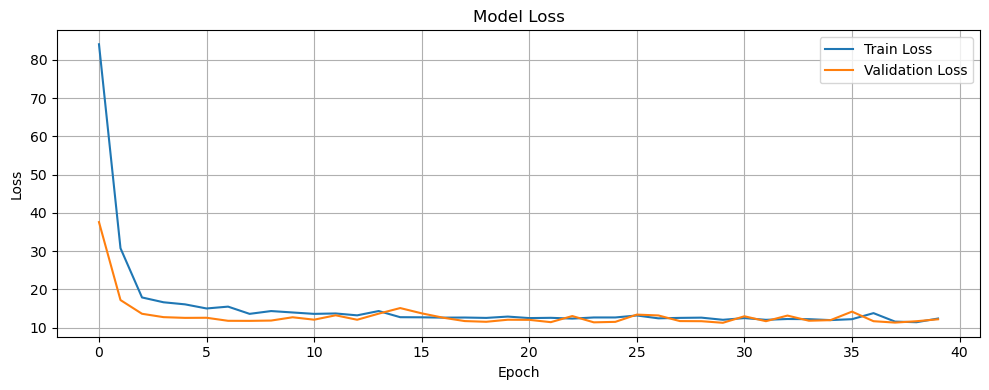

In [84]:
plot_loss(history)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


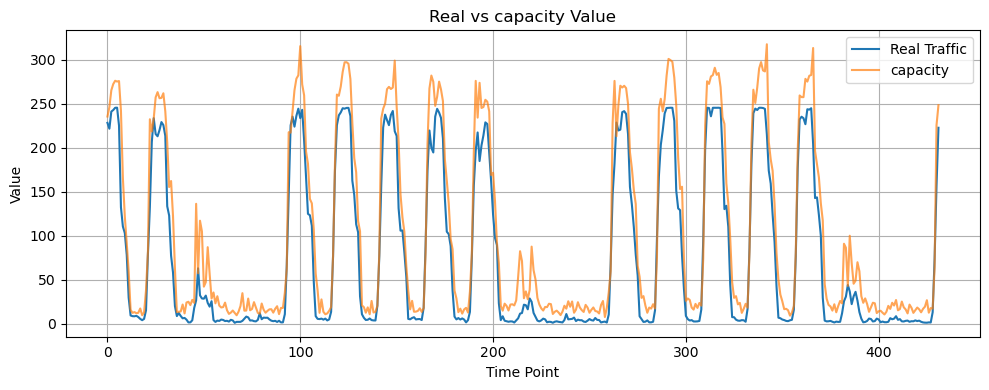

In [90]:
plot_predictions(model, X_test_adv, y_test, start=0, end=500, label="capacity")

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


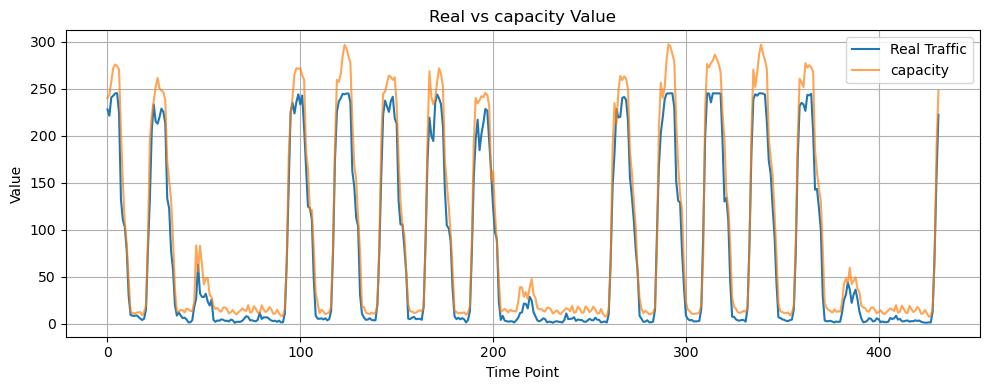

In [91]:
plot_predictions(model, X_test, y_test, start=0, end=500, label="capacity")

In [87]:
violation_rate, num_violations, total = compute_violation_rate(model, X_test, y_test)
print(f"違約率: {violation_rate*100:.2f}% ({num_violations}/{total})")

violation_rate, num_violations, total = compute_violation_rate(model, X_test_adv, y_test)
print(f"違約率: {violation_rate*100:.2f}% ({num_violations}/{total})")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
違約率: 4.63% (20/432)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
違約率: 3.47% (15/432)


In [66]:
# 看 Capacity 差多少
print("未注入")
predicted = model.predict(X_test).reshape(-1, 1)
result_normal = evaluate_regression(y_test, predicted)
print("已注入")
# 看 Capacity 差多少（被注入）
predicted = model.predict(X_test_adv).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

未注入
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Absolute Error: 21.02749252319336
Mean Squared Error: 722.0870971679688
Root Mean Squared Error: 26.87167834669001
R^2 Score: 0.917060375213623
Mean Absolute Percentage Error: 2.110647201538086
已注入
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error: 32.4913330078125
Mean Squared Error: 1715.046630859375
Root Mean Squared Error: 41.4131214817161
R^2 Score: 0.8030081391334534
Mean Absolute Percentage Error: 3.8398265838623047


In [67]:
# Create a DataFrame to compare the values
# 看 Capacity 差多少
df_compare = pd.DataFrame({
    'Metric': list(result_normal.keys()),
    'Normal': list(result_normal.values()),
    'Attacked': list(result_attacked.values())
})

# Calculate absolute and percentage differences
df_compare['Absolute Difference'] = df_compare['Attacked'] - df_compare['Normal']
df_compare['% Difference'] = ((df_compare['Absolute Difference'] / df_compare['Normal']) * 100)
df_compare

,Metric,Normal,Attacked,Absolute Difference,% Difference
0,MAE,21.027493,32.491333,11.463840,54.518343
1,MSE,722.087097,1715.046631,992.959534,137.512433
2,RMSE,26.871678,41.413121,14.541443,54.114384
3,R2,0.917060,0.803008,-0.114052,-12.436721
4,MAPE,2.110647,3.839827,1.729179,81.926500
